# Home2
Your home away from home <br>
The best location for your needs, anywhere in the world <br>
### Inputs: 
    Addresses (eg. 'Pune, Maharashtra')
    Category List (eg. 'Food', 'Restaurant', 'Gym', 'Trails', 'School', 'Train Station')
    Limit of Results to return (eg. 75)
    Radius of search in metres (eg. 10,000)
    Radiums of hotels to search
### Outputs:
    Cluster of venues coded by criteria
    map of cluster
    Centroid latitude and longitude for these venues
    Address near centroid
    Hotels near centroid

## User Input

In [1]:
# Addresses to analyze venues around and obtain best location
addresses=['Bend, Oregon'] 
# 4square Venue categories of interest (https://developer.foursquare.com/docs/build-with-foursquare/categories)
categories=['museum','thai restaurant','gym','night market','national park','state/provincial park','trail']  
# Radius of search in km (maximum 100)
radius=20
# Radius in km to search hotels around from final optimum location (centroid). This list is also sorted by likes    
hotel_radius=20 
# Remove Outliers? 'Y' or 'N'
remove_outliers='Y'

## Import Libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import math

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
 

print('Libraries imported.')

Libraries imported.


'pip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# Limit of search results  
LIMIT=50
radius,hotel_radius=radius*1000,hotel_radius*1000

## Functions and Classes

In [4]:
def build_tree(data, parent=None):
    from anytree import Node, RenderTree
    # Define the root node inside the function
    root = Node("root")
    def _build_tree(data, parent):
        if isinstance(data, dict):
            for key, value in data.items():
                node = Node(key, parent=parent)
                _build_tree(value, node)
        elif isinstance(data, list):
            for index, item in enumerate(data):
                node = Node(f'Item {index}', parent=parent)
                _build_tree(item, node)
        else:
            Node(data, parent=parent)
    # Build the tree from the JSON data
    _build_tree(data, root)
    # Print the tree
    for pre, fill, node in RenderTree(root):
        print(f"{pre}{node.name}")
        
def extract_name_id_pairs(dictionary):
    var = {}
    def explore_dict(d):
        if isinstance(d, dict):
            if 'name' in d and 'id' in d:
                var[d['name'].lower()] = d['id']
            for key, value in d.items():
                explore_dict(value)
        elif isinstance(d, list):
            for item in d:
                explore_dict(item)
    explore_dict(dictionary)
    return var


<b> Function to get centroids from a df of addresses </b>

In [5]:
def centroids(address_df):
    ''' Returns the centroid of a df of addresses as a dictionary of address:(lat,long)'''
    centroid_dict={address:(address_df[address_df.Address==address]['Venue Latitude'].mean(),address_df[address_df.Address==address]['Venue Longitude'].mean()) for address in addresses}
    return centroid_dict

## Obtain Location and Venue information in a Dataframe

### Create Geolocator using Nominatim and Obtain Location info. for the addresses

In [6]:
geoagent="explorer"

lat=[]
long=[]
for address in addresses:
    geolocator = Nominatim(user_agent=geoagent)
    loc = geolocator.geocode(address)
    lat.append(loc.latitude)
    long.append(loc.longitude)
    print('The geograpical coordinates of '+address +' are {}, {}.'.format(lat[-1], long[-1]))



The geograpical coordinates of Bend, Oregon are 44.0581728, -121.3153096.


In [7]:
df_loc=pd.DataFrame({'Name': addresses,'Latitude': lat, 'Longitude':long})
df_loc

,Name,Latitude,Longitude
0,"Bend, Oregon",44.058173,-121.31531


### Foursquare Credentials

In [8]:
CLIENT_ID = 'KB1MA3E55GWTISTXW0GT5LZU1IXBUUDU4VW4QXSKHOQDEVMP' # your Foursquare ID
CLIENT_SECRET = '33L0T0LN54ETAGYXW0W41JCF5CLWHNOUCROOE4NMCUWHTZQA' # your Foursquare Secret
VERSION = '20240725' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KB1MA3E55GWTISTXW0GT5LZU1IXBUUDU4VW4QXSKHOQDEVMP
CLIENT_SECRET:33L0T0LN54ETAGYXW0W41JCF5CLWHNOUCROOE4NMCUWHTZQA


### Make list of category names by ID

In [9]:
categories_url='https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(CLIENT_ID,
                                                                                                            CLIENT_SECRET,
                                                                                                            VERSION)
result=requests.get(categories_url).json()
# build_tree(resut)
# Build the tree from the JSON data
cat_info=result['response']['categories']

category_dict=extract_name_id_pairs(cat_info)
categories=[category_dict[cat.lower()] for cat in categories if cat in list(category_dict.keys()) ]
cat_dict = {value: key for key, value in category_dict.items()}

In [10]:
# General Search URL string
url_str='https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'
# Zipcode Search URL string
url_str_zip='https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'

### Explore nearby venues

<b> Function to get nearby venues matching the "categories" given address </b>

In [11]:
def getNearbyVenues(names, latitudes, longitudes,url_link,categories, radius):
    ''' Create the venue search url and lookup nearby venues and return as dataframe'''
    venues_list=[]
    for i in range(len(names)):
        name=names[i]
        lat=latitudes[i]
        lng = longitudes[i]
        for category in categories:    
            # create the API request URL
            url = url_link.format(
                category,
                CLIENT_ID, 
                CLIENT_SECRET, 
                lat, 
                lng, 
                VERSION,
                radius,
                LIMIT)
            # make the GET request
            results = requests.get(url).json()            
            try:
                # return only relevant information for each nearby venue
                for j in range(len(results['response']['venues'])):
                        venues_list.append([
                        name, 
                        results['response']['venues'][j]['name'],
                        results['response']['venues'][j]['id'],
                        results['response']['venues'][j]['location']['lat'], 
                        results['response']['venues'][j]['location']['lng'],  
                        results['response']['venues'][j]['categories'][0]['name'],
                        category, 
                        results['response']['venues'][j]['location']['distance'],
                        ])
            except Exception as E:
                    print(E)
        
    nearby_venues = pd.DataFrame(venues_list)
    nearby_venues.columns = ['Address', 
              'Venue', 
              'Venue_id',
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category',
              'Category ID',
              'Distance [m]']
        
    return(nearby_venues)

def getVenueLikes(venue_ids):
    ''' Obtain the list of number of likes for the venues in "venue_ids"'''
    likes_list=[]
    for i in range(len(venue_ids)): 
        # create the API request URL
        url_link='https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'
        url = url_link.format(venue_ids[i],
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION)


        # make the GET request
        results = requests.get(url).json()
        
        likes_list.append(results['response']['venue']['likes']['count'])

       
    return(likes_list)

Dataframe of Venues for each address, matching the "categories"

In [12]:
# Implement 'getNearbyVenues'
loc_venues=getNearbyVenues(df_loc['Name'], df_loc['Latitude'],df_loc['Longitude'],url_str,categories,radius)

loc_venues.head()

,Address,Venue,Venue_id,Venue Latitude,Venue Longitude,Venue Category,Category ID,Distance [m]
0,"Bend, Oregon",Deschutes Historical Museum,4ccb7562063a721eb3ff879a,44.055381,-121.316909,History Museum,4bf58dd8d48988d181941735,336
1,"Bend, Oregon",Sunriver Observatory,4f125b2fe4b0a6ade14b6faf,43.885204,-121.447711,Science Museum,4bf58dd8d48988d181941735,21983
2,"Bend, Oregon",Petersen Rock Museum,4c3b80115810a593a9c4ba3c,44.203122,-121.262437,Public Art,4bf58dd8d48988d181941735,16679
3,"Bend, Oregon",High Desert Museum,4b63435ff964a520656e2ae3,43.966331,-121.343029,Museum,4bf58dd8d48988d181941735,10461
4,"Bend, Oregon",Typhoon! Bend,4b50e465f964a520443727e3,44.057620,-121.313610,Thai Restaurant,4bf58dd8d48988d149941735,149


## Pre-Processing

Drop NaN values, set 'Venue' as index column since we are dealing with venues.

In [13]:
loc_venues.set_index('Venue',inplace=True)
loc_venues.dropna(inplace=True)
loc_venues.head()
loc_venues.shape

(55, 7)

Print number of categories for each address

In [14]:
for i in range(len(addresses)):
    print('There are {} uniques categories for '
          .format(len(loc_venues.loc[loc_venues['Address']==addresses[i],'Venue Category'].unique()))+addresses[i])

There are 15 uniques categories for Bend, Oregon


## Exploratory Data Analysis

In [15]:
# Calculate centroid of the venues for each address in loc_venues
loc_venues_centroids=centroids(loc_venues)
print(loc_venues_centroids)

{'Bend, Oregon': (44.057527817174346, -121.31497519887749)}


### Make Folium plot to show venues

In [16]:
maps={}
loc_results_lat=[]
loc_results_long=[]
zip_results={}

i=0
for address in addresses:
    # create map
    clustered=loc_venues[loc_venues['Address']==address]
    lat_array=clustered['Venue Latitude']
    long_array=clustered['Venue Longitude']
    venue_name=clustered.index
    
    # Calculate mean latitude and longitude
    latitude=lat_array.mean()                            
    longitude=long_array.mean()
    
    # Update results latitude and longitude arrays
    loc_results_lat.append(latitude)
    loc_results_long.append(longitude)
    
    # Obtain Zipcode
    url_zip=url_str_zip.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION,500,1)
    zip_result=requests.get(url_zip).json()
    try:
        zip_results[address]=zip_result['response']['venues'][0]['location']['formattedAddress']
    except:
        zip_results[address]='0'
    
    print('Centroid for '+str(address)+' at: '+str(round(latitude,5))+', '+str(round(longitude,5))
          +', Address:',zip_results[address][0])

    map_clusters = folium.Map(location=[latitude, longitude],zoom_start=10)

    # add markers to the map
    markers_colors = []
    for lat, lon, name in zip(lat_array, long_array, 
                                 venue_name     ):
        label = folium.Popup(name, parse_html=True)
        folium.Marker(
            [lat, lon],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
                            ).add_to(map_clusters)
        
    folium.RegularPolygonMarker(location=[latitude, longitude], 
                                number_of_sides=5,
                                popup='Centroid', 
                                color='red', 
                                fill=True,
                                fill_color='yellow',
                                fill_opacity=0.8).add_to(map_clusters)
    
    maps[address]=map_clusters
    i=i+1

lat1=latitude
long1=longitude
maps[addresses[0]]


Centroid for Bend, Oregon at: 44.05753, -121.31498, Address: 812 NW Wall St


### Make Venue Longitude and Latitude box plots

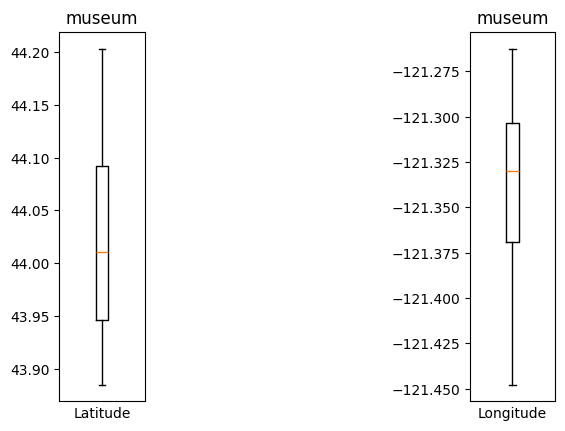

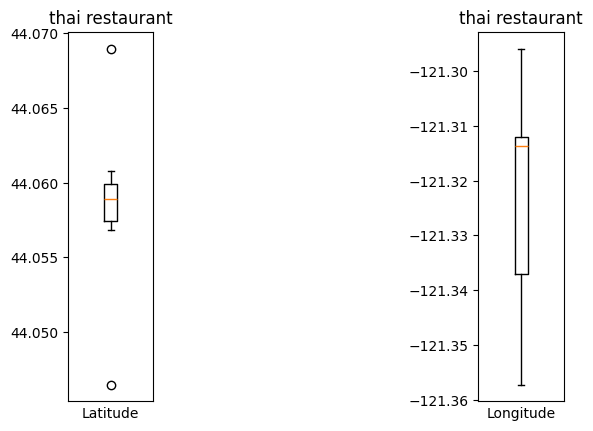

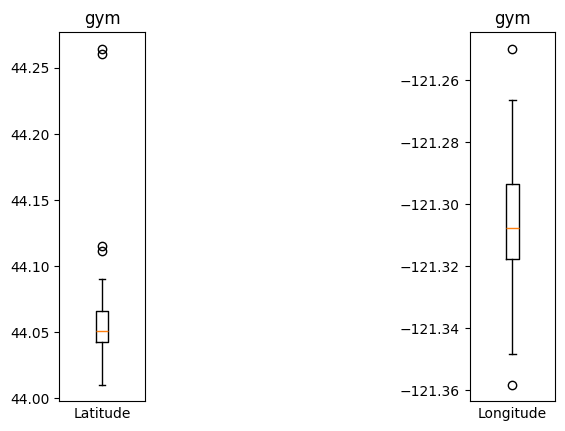

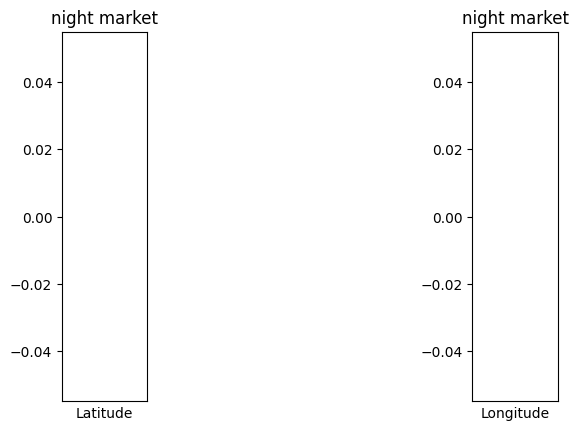

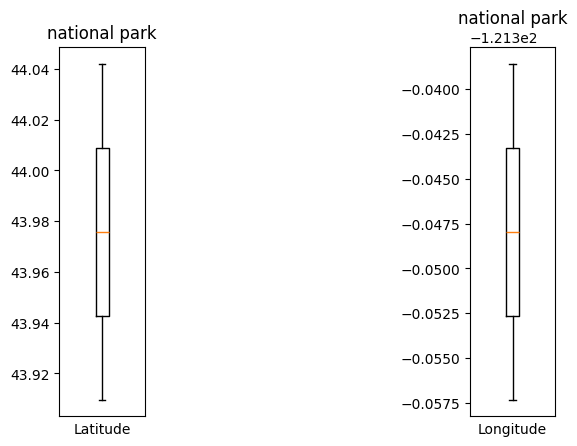

In [17]:
fnum=1

unique_cat=len(loc_venues['Category ID'].unique())+1
bp={}                                                   # Box plot object dict.

for i in range(0,unique_cat):
    plt.figure()
    plt.subplot(1,5,1)
    Y=loc_venues.loc[loc_venues['Category ID']==categories[i],'Venue Latitude']
    bp[categories[i]+'.Latitude']=(plt.boxplot(Y))
    plt.xlabel('Latitude')
    plt.xticks([])
    plt.title(str(cat_dict[categories[i]]))

    plt.subplot(1,5,5)
    Y=loc_venues.loc[loc_venues['Category ID']==categories[i],'Venue Longitude']
    bp[categories[i]+'.Longitude']=(plt.boxplot(Y))
    plt.xlabel('Longitude')
    plt.xticks([])
    plt.title(str(cat_dict[categories[i]]))

fnum=fnum+1

Remove the outliers from data, by referencing the category ID and latitude/longitude values

(35, 7)

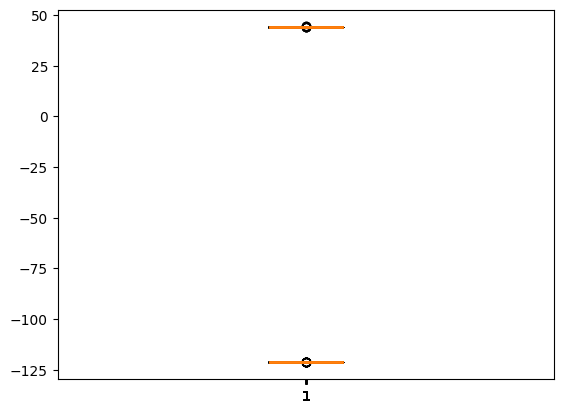

In [18]:
if remove_outliers=='Y':
    flag=1
    while flag==1:
        flag=0
        for category in categories:

            Y=loc_venues.loc[loc_venues['Category ID']==category,'Venue Latitude']
            bp[category+'.Latitude']=plt.boxplot(Y)
            Y=loc_venues.loc[loc_venues['Category ID']==category,'Venue Longitude']
            bp[category+'.Longitude']=plt.boxplot(Y)

            outliers_lat=bp[category+'.Latitude']['fliers'][0].get_data()[1]
            outliers_long=bp[category+'.Longitude']['fliers'][0].get_data()[1]
            if len(outliers_lat)>0 or len(outliers_long)>0:
                flag=1
            for outlier_lat in outliers_lat:
                idx1=loc_venues['Category ID']==category
                idx2=loc_venues['Venue Latitude']==outlier_lat
                idx1=idx1[idx1==True].index
                idx2=idx2[idx2==True].index
                loc_venues.drop(idx1.intersection(idx2),axis=0,inplace=True)
            for outlier_long in outliers_long:
                idx1=loc_venues['Category ID']==category
                idx2=loc_venues['Venue Longitude']==outlier_long
                idx1=idx1[idx1==True].index
                idx2=idx2[idx2==True].index
                loc_venues.drop(idx1.intersection(idx2),axis=0,inplace=True)
loc_venues.shape

Re-Plot the box plots to check that there are no outliers remaining

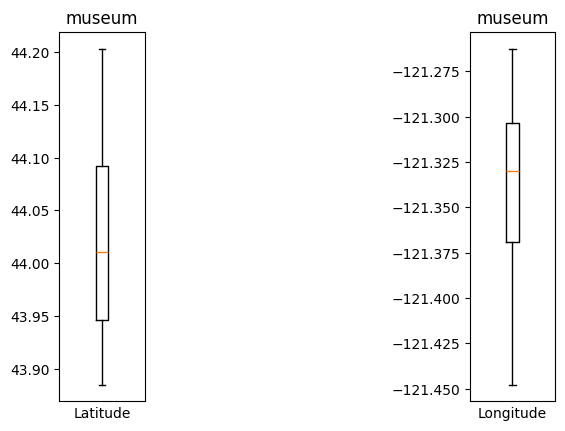

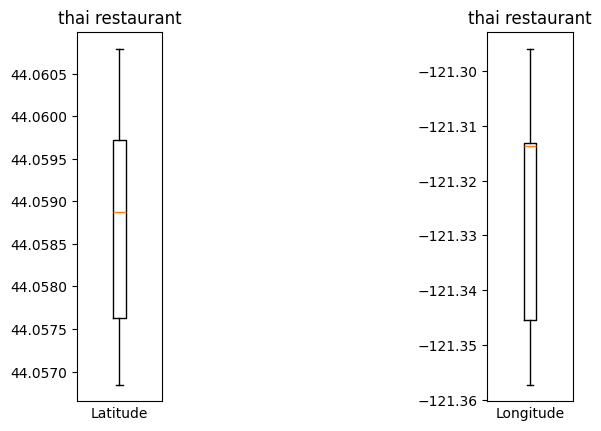

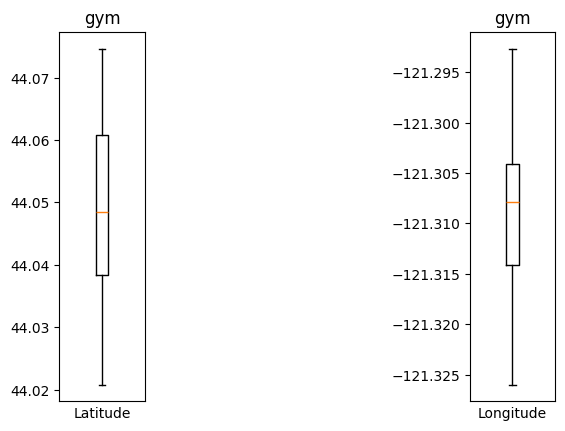

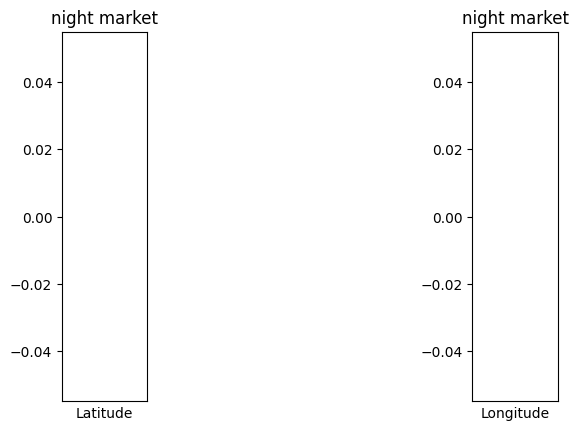

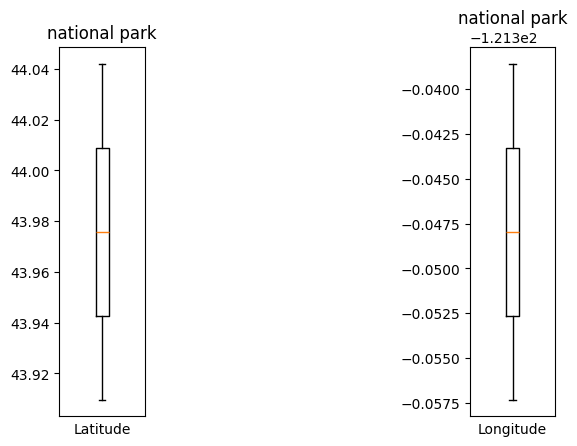

In [19]:
fnum=1

unique_cat=len(loc_venues['Category ID'].unique())+1
bp={}                                                   # Box plot object dict.

for i in range(0,unique_cat):
    plt.figure()
    plt.subplot(1,5,1)
    Y=loc_venues.loc[loc_venues['Category ID']==categories[i],'Venue Latitude']
    bp[categories[i]+'.Latitude']=(plt.boxplot(Y))
    plt.xlabel('Latitude')
    plt.xticks([])
    plt.title(str(cat_dict[categories[i]]))

    plt.subplot(1,5,5)
    Y=loc_venues.loc[loc_venues['Category ID']==categories[i],'Venue Longitude']
    bp[categories[i]+'.Longitude']=(plt.boxplot(Y))
    plt.xlabel('Longitude')
    plt.xticks([])
    plt.title(str(cat_dict[categories[i]]))

fnum=fnum+1

Re-plot the folium plot

In [20]:
maps={}
loc_results_lat=[]
loc_results_long=[]
zip_results={}

i=0
for address in addresses:
    # create map
    clustered=loc_venues[loc_venues['Address']==address]
    lat_array=clustered['Venue Latitude']
    long_array=clustered['Venue Longitude']
    venue_name=clustered.index
    
    # Calculate mean latitude and longitude
    latitude=lat_array.mean()                            
    longitude=long_array.mean()
    
    # Update results latitude and longitude arrays
    loc_results_lat.append(latitude)
    loc_results_long.append(longitude)
    
    # Obtain Zipcode
    url_zip=url_str_zip.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION,500,1)
    zip_result=requests.get(url_zip).json()
    try:
        zip_results[address]=zip_result['response']['venues'][0]['location']['formattedAddress']
    except:
        zip_results[address]='0'
    
    print('Centroid for '+str(address)+' at: '+str(round(latitude,5))+', '+str(round(longitude,5))
          +', Address:',zip_results[address][0])

    map_clusters = folium.Map(location=[latitude, longitude],zoom_start=10)

    # add markers to the map
    markers_colors = []
    for lat, lon, name in zip(lat_array, long_array, 
                                 venue_name     ):
        label = folium.Popup(name, parse_html=True)
        folium.Marker(
            [lat, lon],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.5,
                            ).add_to(map_clusters)
    
    folium.RegularPolygonMarker(location=[latitude, longitude], 
                                number_of_sides=5,
                                popup='Centroid', 
                                color='red', 
                                fill_color='yellow',
                                fill_opacity=0.8).add_to(map_clusters)
    
    maps[address]=map_clusters
    i=i+1
lat2=latitude
long2=longitude
maps[addresses[-1]]

Centroid for Bend, Oregon at: 44.04559, -121.31943, Address: 975 SW Colorado Ave


### New dataframe for the venues with outliers removed and distance calculated from new centroid

In [21]:
loc_venues_new=getNearbyVenues(df_loc['Name'], loc_results_lat,loc_results_long,url_str,categories,radius)
loc_venues_new.head()

,Address,Venue,Venue_id,Venue Latitude,Venue Longitude,Venue Category,Category ID,Distance [m]
0,"Bend, Oregon",Deschutes Historical Museum,4ccb7562063a721eb3ff879a,44.055381,-121.316909,History Museum,4bf58dd8d48988d181941735,1107
1,"Bend, Oregon",Sunriver Observatory,4f125b2fe4b0a6ade14b6faf,43.885204,-121.447711,Science Museum,4bf58dd8d48988d181941735,20601
2,"Bend, Oregon",Petersen Rock Museum,4c3b80115810a593a9c4ba3c,44.203122,-121.262437,Public Art,4bf58dd8d48988d181941735,18117
3,"Bend, Oregon",High Desert Museum,4b63435ff964a520656e2ae3,43.966331,-121.343029,Museum,4bf58dd8d48988d181941735,9023
4,"Bend, Oregon",Typhoon! Bend,4b50e465f964a520443727e3,44.057620,-121.313610,Thai Restaurant,4bf58dd8d48988d149941735,1417


Centroid after omitting outliers:

In [22]:
loc_venues_new_centroids=centroids(loc_venues_new)

In [23]:
# Find common venues between initial and outlier adjusted venue list
set_loc_venues=set(loc_venues['Venue_id'].tolist())
set_loc_venues_new=set(loc_venues_new['Venue_id'].tolist())
list_common_venues=list(set_loc_venues.intersection(set_loc_venues_new))

In [24]:
#Filter loc_venues_new to common venue ids
loc_venues_new=loc_venues_new.set_index(['Venue_id']).loc[list_common_venues,:].reset_index()
loc_venues_new.head()

,Venue_id,Address,Venue,Venue Latitude,Venue Longitude,Venue Category,Category ID,Distance [m]
0,60d240d0cf5d8f41a86706a8,"Bend, Oregon",Sen Thai Noodles & Hot Pot,44.060795,-121.314042,Thai Restaurant,4bf58dd8d48988d149941735,1746
1,4c94de62f7cfa1cd2dacb715,"Bend, Oregon",Aspire Sport And Fitness,44.074651,-121.302928,Gym,4bf58dd8d48988d176941735,3493
2,4bccb3c9cc8cd13aa56bc1cf,"Bend, Oregon",Renew Fitness,44.060294,-121.297502,Gym,4bf58dd8d48988d176941735,2398
3,4f4c336ee4b0f9202351550a,"Bend, Oregon",Deschutes County Rocks Boxing,44.060158,-121.307434,Gym,4bf58dd8d48988d176941735,1883
4,4e3abfc87d8b90abc32a5736,"Bend, Oregon",Max Fitness,44.032113,-121.307775,Gym and Studio,4bf58dd8d48988d176941735,1766


In [25]:
#Sum of distances between centroid before and after removing outliers
dist_1=loc_venues['Distance [m]'].mean()/1000
print('Mean distance between venues and centroid is {} km.'.format(dist_1))
if remove_outliers=='Y':
    dist_2=loc_venues.set_index(['Venue_id']).loc[list_common_venues,:]['Distance [m]'].mean()/1000
    dist_3=loc_venues_new['Distance [m]'].mean()/1000
    # Print values
    print('Mean distance between non-outlier venues and centroid before removing outliers is {} km.'.format(dist_1))
    print('Mean distance between non-outlier venues and centroid after removing outliers is {} km.'.format(dist_2))
    print('Difference in mean distance between non-outlier venues and centroid before and after removing outliers is {} km'.
         format(dist_2-dist_3))
    print('Difference in mean distance between venues and centroid before and after removing outliers is {} km'.
         format(dist_1-dist_3))

Mean distance between venues and centroid is 3.299114285714286 km.
Mean distance between non-outlier venues and centroid before removing outliers is 3.299114285714286 km.
Mean distance between non-outlier venues and centroid after removing outliers is 3.299114285714286 km.
Difference in mean distance between non-outlier venues and centroid before and after removing outliers is -0.16425714285714266 km
Difference in mean distance between venues and centroid before and after removing outliers is -0.16425714285714266 km


### Geo-distance shift in coordinates

Define function to calculate distance based on geo-coordinates

In [26]:
def geodistance (coord1,coord2):
    R = 6373.0                          ## Radius of Earth in kms.
    latd1 = math.radians(coord1[0])     # Latitude of coord1 calculated in radians
    lon1 = math.radians(coord1[1])     # Longitude of coord1 calculated in radians
    latd2 = math.radians(coord2[0])     # Latitude of coord2 calculated in radians
    lon2 = math.radians(coord2[1])     # Longitude of coord2 calculated in radians

    dlon = lon2 - lon1
    dlat = latd2 - latd1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c * 1000                    # Geo-distance in kms.
    return distance

Distance shift in centroid after omitting the outliers:

In [27]:
shift_outlier={address:round(geodistance((loc_venues_centroids[address][0], loc_venues_centroids[address][1]),
                                   (loc_venues_new_centroids[address][0],loc_venues_new_centroids[address][1]))/1000,2) for address in addresses}
print('Geo-Distance shift in kms in Centroid before and after removing outliers is: ',shift_outlier )

Geo-Distance shift in kms in Centroid before and after removing outliers is:  {'Bend, Oregon': 0.89}


## Encoding Venue Categories

In [28]:
cat_num_dict={cat_id:i for i,cat_id in enumerate(loc_venues_new['Category ID'].unique())}
loc_venues_new['Cluster Labels']=loc_venues_new['Category ID'].apply(lambda x:cat_num_dict[x])
loc_venues_new.head()

,Venue_id,Address,Venue,Venue Latitude,Venue Longitude,Venue Category,Category ID,Distance [m],Cluster Labels
0,60d240d0cf5d8f41a86706a8,"Bend, Oregon",Sen Thai Noodles & Hot Pot,44.060795,-121.314042,Thai Restaurant,4bf58dd8d48988d149941735,1746,0
1,4c94de62f7cfa1cd2dacb715,"Bend, Oregon",Aspire Sport And Fitness,44.074651,-121.302928,Gym,4bf58dd8d48988d176941735,3493,1
2,4bccb3c9cc8cd13aa56bc1cf,"Bend, Oregon",Renew Fitness,44.060294,-121.297502,Gym,4bf58dd8d48988d176941735,2398,1
3,4f4c336ee4b0f9202351550a,"Bend, Oregon",Deschutes County Rocks Boxing,44.060158,-121.307434,Gym,4bf58dd8d48988d176941735,1883,1
4,4e3abfc87d8b90abc32a5736,"Bend, Oregon",Max Fitness,44.032113,-121.307775,Gym and Studio,4bf58dd8d48988d176941735,1766,1


## Display Results

### Generate analyzed map array for each address using folium, and display location for each address

In [29]:
maps={}
loc_results_lat=[]
loc_results_long=[]
zip_results={}

kclusters=max(loc_venues_new['Cluster Labels'])+1

for i,address in enumerate(addresses):
    # create map
    clustered=loc_venues_new[loc_venues_new['Address']==address]
    lat_array=clustered['Venue Latitude']
    long_array=clustered['Venue Longitude']
    
    # Calculate mean latitude and longitude
    latitude=loc_venues_new_centroids[address][0]                        
    longitude=loc_venues_new_centroids[address][1] 
    
    # Update results latitude and longitude arrays
    loc_results_lat.append(latitude)
    loc_results_long.append(longitude)
    
    # Obtain Zipcode
    url_zip=url_str_zip.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION,500,1)
    zip_result=requests.get(url_zip).json()
    try:
        zip_results[address]=zip_result['response']['venues'][0]['location']['formattedAddress']
    except:
        zip_results[address]='0'
    
    print('Centroid at: '+str(round(latitude,5))+', '+str(round(longitude,5))
          +', Address:',zip_results[address][0])

    map_clusters = folium.Map(location=[latitude, longitude],zoom_start=10)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [j + x + (j*x)**2 for j in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(j) for j in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster, category in zip(lat_array, long_array, 
                                      clustered.index, clustered['Cluster Labels'], clustered['Category ID']):
        label = folium.Popup(str(poi) + ' Cluster: ' + str(cat_dict[category]), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7,
                            ).add_to(map_clusters)
    
    folium.RegularPolygonMarker(location=[latitude, longitude], 
                                number_of_sides=5,
                                popup='Centroid', 
                                color='red', 
                                fill=True,
                                fill_color='yellow',
                                fill_opacity=0.8, 
                                radius=7).add_to(map_clusters)
    
    maps[address]=map_clusters
maps[address]

Centroid at: 44.0498, -121.31705, Address: 803 SW Industrial Way


### Get hotels near venues

In [32]:
hotel_category=['4bf58dd8d48988d1fa931735']                # Category for Hotels

# Enter Hotel Search URL string
url_str_hotels='https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'

df_hotels=df_loc.copy()

df_hotels['Latitude']=[value[0] for value in loc_venues_new_centroids.values()] 
df_hotels['Longitude']=[value[1] for value in loc_venues_new_centroids.values()]
# Get hotels list
hotels=getNearbyVenues(names=df_hotels['Name'], latitudes=df_hotels['Latitude'],longitudes=df_hotels['Longitude'],
                       url_link=url_str_hotels,categories=hotel_category,radius=hotel_radius)

hotel_ids=hotels['Venue_id'].tolist()
# Get Likes list for hotels
likes_list=getVenueLikes(hotel_ids)

hotels['Likes']=likes_list
hotels['Distance [km]']=(hotels['Distance [m]']/1000).astype(int)

hotels.drop(columns=['Category ID','Venue_id','Distance [m]'],inplace=True)
hotels.sort_values(by=['Likes','Distance [km]'],ascending=[False,True],inplace=True)
hotels.set_index('Venue',drop=True,inplace=True)

# Cluster hotels by likes from 1 to 4
likes_clusters=np.arange(1,5)
likes_bracket=np.linspace(0,max(likes_list),5)
hotels['Cluster Labels'] = hotels['Likes'].apply(lambda z: next((
    likes_clusters[i] for i in range(len(likes_clusters)) if likes_bracket[i] <= z < likes_bracket[i + 1]), 
    likes_clusters[-1] if z == likes_bracket[-1] else None))

hotels.drop(columns=['Cluster Labels'])

,Address,Venue Latitude,Venue Longitude,Venue Category,Likes,Distance [km]
Venue,,,,,,
Sunriver Resort,"Bend, Oregon",43.873991,-121.446471,Resort,83,22
Riverhouse on the Deschutes,"Bend, Oregon",44.079231,-121.305370,Hotel,37,3
The Oxford Hotel,"Bend, Oregon",44.057747,-121.312222,Hotel,19,0
Fairfield Inn & Suites Bend Downtown,"Bend, Oregon",44.066474,-121.308305,Hotel,18,1
WorldMark Bend - Seventh Mountain Resort,"Bend, Oregon",43.996047,-121.397476,Hotel,18,8
TownePlace Suites Bend,"Bend, Oregon",44.042342,-121.331271,Hotel,11,1
Hampton Inn by Hilton,"Bend, Oregon",44.044355,-121.318257,Hotel,10,0
Residence Inn By Marriott Bend,"Bend, Oregon",44.044976,-121.310235,Hotel,8,0
SpringHill Suites by Marriott Bend,"Bend, Oregon",44.049909,-121.315307,Hotel,7,0


### Plot map

In [31]:
hotel_maps={}
zip_results={}
kclusters=max(loc_venues_new['Cluster Labels'])+1

for i,address in enumerate(addresses):
    clustered=hotels[hotels.Address==address]

    lat_array=clustered['Venue Latitude']
    long_array=clustered['Venue Longitude']
    
    # Calculate mean latitude and longitude
    latitude=loc_venues_new_centroids[address][0]                           
    longitude=loc_venues_new_centroids[address][1]
        
    # create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
    
    # Obtain Zipcode
    url_zip=url_str_zip.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION,500,1)
    zip_result=requests.get(url_zip).json()
    try:
        zip_results[address]=zip_result['response']['venues'][0]['location']['formattedAddress']
    except:
        zip_results[address]='0'
    
    print('Centroid at: ' +str(round(latitude,5))+', '+str(round(longitude,5))
          +',Centroid Address:',zip_results[address][0])

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [j + x + (j*x)**2 for j in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)+1))
    rainbow = [colors.rgb2hex(j) for j in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(lat_array, long_array, 
                                    clustered.index, clustered['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Rating(/4): ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7,
                            ).add_to(map_clusters)
    folium.RegularPolygonMarker(location=[latitude, longitude], 
                            number_of_sides=5,
                            popup='Centroid', 
                            color='red', 
                            fill=True,
                            fill_color='yellow',
                            fill_opacity=0.8).add_to(map_clusters)
    
    hotel_maps[address]=map_clusters
hotel_maps[address]

Centroid at: 44.0498, -121.31705,Centroid Address: 803 SW Industrial Way
